In [ ]:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
controls = sio.loadmat("controles-pacientes-realtime.mat")["prob_h"]
patients = sio.loadmat("controles-pacientes-realtime.mat")["prob_p"]

data = np.concatenate((controls, patients), axis=1).T
labels = np.hstack((np.repeat(0, 24), np.repeat(1, 41)))

data.shape, labels.shape

((65, 5), (65,))

In [ ]:
loo = LeaveOneOut()
y_true, y_pred, y_scores = [], [], []

for train_index, test_index in loo.split(data):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    model = LogisticRegression()
    model.fit(X_train_resampled, y_train_resampled)
    prob = model.predict_proba(X_test)[:, 1]

    y_true.append(y_test[0])
    y_scores.append(prob[0])

    pred = model.predict(X_test)
    y_pred.append(pred[0])


accuracy = accuracy_score(y_true, y_pred)

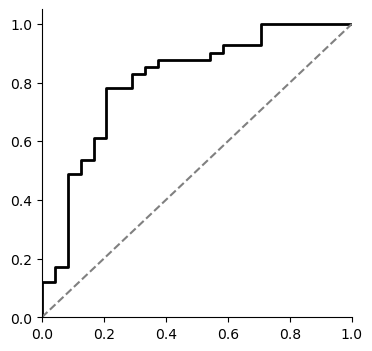

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(fpr, tpr, color='black', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.spines[['right', 'top']].set_visible(False)

plt.savefig("roc.eps")

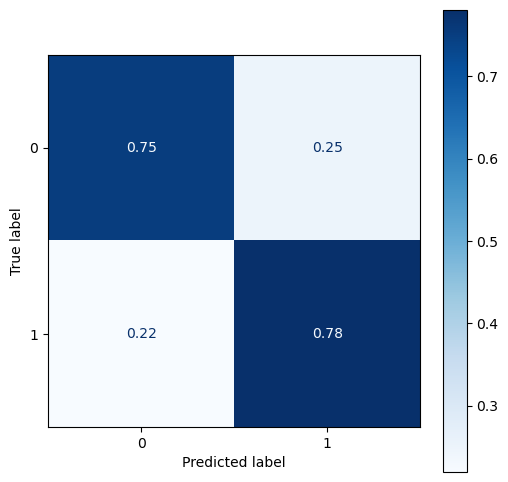

In [136]:
cm = confusion_matrix(y_true, y_pred, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.savefig("confusion_matrix.eps")